<a href="https://colab.research.google.com/github/walwi878/AIML428-Text-Classification/blob/main/AIML428_Text_Classification_Customer_complaints_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#AIML428 Project - Text classification
#William Wallace
#17/04/21
#This project was very much helped using the following sources:
#https://medium.com/swlh/multi-class-text-classification-using-scikit-learn-a9bacb751048
#https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/

#Link to this code on the smaller stack-overflow-data.csv dataset:
#https://colab.research.google.com/drive/1nx9zAwvIKjEntLCSvdmkdUiJ4IbcdKFO#scrollTo=MS1BHGXPFxz0

import logging
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
import re
from bs4 import BeautifulSoup
from sklearn.metrics import classification_report

%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#Checking out the data

from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/complaints_cleaned_v10.csv')
df = df[pd.notnull(df['tags'])]
df.head(10)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,posts,tags
0,-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -...,Debt collection
1,- Agent of company threatened garnishment prio...,Debt collection
2,- American express card went to collection in ...,Debt collection
3,"- Collection agency I.C System, Inc XXXX XXXX ...",Debt collection
4,"- Company name : FIRSTSOURCE ADVANTAGE , LLC -...",Debt collection
5,"-- Debt collector XXXX collections, tax id XXX...",Debt collection
6,- I found an entry from ONLINE INFORMATION SER...,Debt collection
7,- I have a collection account for $5300.00} wi...,Debt collection
8,- I purchased 1 laptop in XX/XX/XXXX - XX/XX/X...,Debt collection
9,- In XX/XX/2019 I spent over an hour on the ph...,Debt collection


In [3]:
df['posts'].apply(lambda x: len(x.split(' '))).sum()

82977936

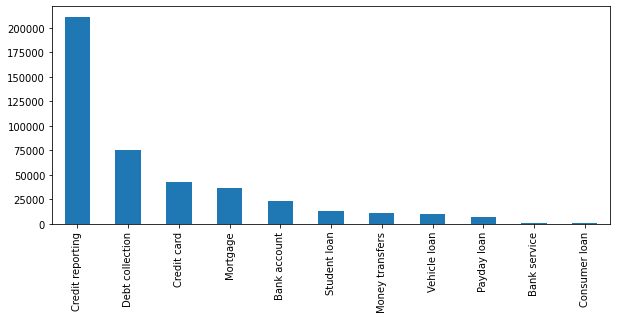

In [4]:
#View the distribution
#source: https://stackoverflow.com/questions/65594438/how-to-plot-histogram-against-class-label-for-tf-dataset
my_tags = ['Debt collection','Credit card','Money transfers','Mortgage','Credit reporting','Bank account','Vehicle loan','Student loan','Consumer loan','Bank service','Payday loan']
plt.figure(figsize=(10,4))
df.tags.value_counts().plot(kind='bar');

In [5]:
def print_plot(index):
    example = df[df.index == index][['posts', 'tags']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Tag:', example[1])

In [6]:

print_plot(10)

- Letter dated XX/XX/2019 requesting Validation of Debt sent to LVNV - Response letter dated XX/XX/2019 with an account summary as Validation of Debt. 
- Response letter dated XX/XX/2019 with an account as Validation of Debt - Another letter dated XX/XX/2019 requesting Validation of Debt not an account summary. 
- NO RESPONSE FROM LVNV
Tag: Debt collection


In [7]:
#Preprocessing the text - i.e. HTML decoding, remove stop words, change text to lower case, remove punctuation, remove bad characters
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text                                     # HTML decoding
    text = text.lower()                                                         # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text)                                   # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text)                                         # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)     # delete stopwors from text
    return text

In [8]:
df['posts'] = df['posts'].apply(clean_text)


In [9]:
#Check to see if data is clean
print_plot(10)


letter dated xx xx 2019 requesting validation debt sent lvnv response letter dated xx xx 2019 account summary validation debt response letter dated xx xx 2019 account validation debt another letter dated xx xx 2019 requesting validation debt account summary response lvnv
Tag: Debt collection


In [10]:
#Check how many words
df['posts'].apply(lambda x: len(x.split(' '))).sum()


43442997

In [11]:
X = df.posts
y = df.tags
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

In [25]:
# Convert text documents to a matrix of token counts (CountVectorizer), 
# transforms a count matrix to a normalized tf-idf representation (tf-idf transformer),
# train several classifiers usign the sci-kit library

#Naive Bayes classifier¶

from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [26]:
#Get accuracy for each class
#source: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
%%time
from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.7027137555073727


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                  precision    recall  f1-score   support

 Debt collection       0.78      0.28      0.41      7166
     Credit card       0.00      0.00      0.00       286
 Money transfers       0.00      0.00      0.00       282
        Mortgage       0.63      0.52      0.57     12727
Credit reporting       0.67      0.98      0.79     63439
    Bank account       0.82      0.53      0.64     22635
    Vehicle loan       0.97      0.08      0.15      3265
    Student loan       0.90      0.73      0.80     10864
   Consumer loan       0.00      0.00      0.00      2164
    Bank service       0.97      0.12      0.21      3818
     Payday loan       0.75      0.00      0.00      2953

        accuracy                           0.70    129599
       macro avg       0.59      0.29      0.33    129599
    weighted avg       0.72      0.70      0.66    129599

CPU times: user 15.2 s, sys: 62.5 ms, total: 15.3 s
Wall time: 15.3 s


In [27]:
#ADDITIONAL FOURTH STEP FOR CURIOUSITY - 
#HOW DOES THIS DATASET PERFORM USING THE METHODS DEVELOPED FROM STEP 3 USED ON STACK-OVERFLOW_DATASET.CSV? 

#Linear support vector machine¶
#source: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html

from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=Non...
                ('clf',
                 SGDClassifier(alpha=0.001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optimal', loss='hinge',
                      

In [28]:
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html

%%time
y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.7828455466477365


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                  precision    recall  f1-score   support

 Debt collection       0.75      0.63      0.68      7166
     Credit card       0.00      0.00      0.00       286
 Money transfers       0.00      0.00      0.00       282
        Mortgage       0.76      0.68      0.72     12727
Credit reporting       0.78      0.94      0.86     63439
    Bank account       0.77      0.66      0.71     22635
    Vehicle loan       0.85      0.47      0.60      3265
    Student loan       0.81      0.89      0.85     10864
   Consumer loan       0.73      0.02      0.03      2164
    Bank service       0.90      0.57      0.70      3818
     Payday loan       0.80      0.11      0.19      2953

        accuracy                           0.78    129599
       macro avg       0.65      0.45      0.49    129599
    weighted avg       0.78      0.78      0.76    129599

CPU times: user 15.1 s, sys: 45.6 ms, total: 15.1 s
Wall time: 15.2 s


In [29]:
#Logistic regression
#source: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 LogisticRegression(C=100000.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=

In [30]:

%%time

y_pred = logreg.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.845384609449147
                  precision    recall  f1-score   support

 Debt collection       0.76      0.81      0.78      7166
     Credit card       0.44      0.03      0.05       286
 Money transfers       0.21      0.01      0.02       282
        Mortgage       0.79      0.80      0.79     12727
Credit reporting       0.89      0.91      0.90     63439
    Bank account       0.80      0.78      0.79     22635
    Vehicle loan       0.79      0.71      0.75      3265
    Student loan       0.90      0.90      0.90     10864
   Consumer loan       0.64      0.49      0.55      2164
    Bank service       0.84      0.80      0.82      3818
     Payday loan       0.67      0.61      0.64      2953

        accuracy                           0.85    129599
       macro avg       0.70      0.62      0.64    129599
    weighted avg       0.84      0.85      0.84    129599

CPU times: user 16.4 s, sys: 57.9 ms, total: 16.5 s
Wall time: 16.6 s


In [25]:

#Word2vec embedding and Logistic Regression
#NOTE - Takes 50 mins to run

#This uses pre-trained  
#source: https://stackoverflow.com/questions/46433778/import-googlenews-vectors-negative300-bin
#source: https://radimrehurek.com/gensim/models/keyedvectors.html

%%time
!brew install wget

!wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
from gensim import models



wv = models.KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin.gz", binary=True)
wv.init_sims(replace=True)

/bin/bash: brew: command not found
--2021-04-24 02:09:09--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.77.190
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.77.190|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

CPU times: user 2min 44s, sys: 5.8 s, total: 2min 50s
Wall time: 2min 52s


In [27]:

#This is to build word vectors for input text in order to average the value of all word vectors in the posts
#source: https://towardsdatascience.com/3-basic-approaches-in-bag-of-words-which-are-better-than-word-embeddings-c2cbc7398016
#source: https://www.guru99.com/word-embedding-word2vec.html
def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.syn0norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(wv.vector_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, posts) for posts in text_list ])

In [28]:
def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens

In [29]:
#This tokenizer divides a text into a list of sentences by building a model for abbreviation words, collocations, and words that start sentences

train, test = train_test_split(df, test_size=0.3, random_state = 42)
nltk.download('punkt')
test_tokenized = test.apply(lambda r: w2v_tokenize_text(r['posts']), axis=1).values
train_tokenized = train.apply(lambda r: w2v_tokenize_text(r['posts']), axis=1).values

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [30]:
X_train_word_average = word_averaging_list(wv,train_tokenized)
X_test_word_average = word_averaging_list(wv,test_tokenized)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.wv.vectors_norm instead).
  


In [31]:

from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(n_jobs=1, C=1e5, max_iter= 10000)
logreg = logreg.fit(X_train_word_average, train['tags'])
y_pred = logreg.predict(X_test_word_average)

In [32]:
from sklearn.metrics import classification_report
print('accuracy %s' % accuracy_score(y_pred, test.tags))
print(classification_report(test.tags, y_pred,target_names=my_tags))

accuracy 0.797205225348961
                  precision    recall  f1-score   support

 Debt collection       0.71      0.74      0.72      7166
     Credit card       0.12      0.01      0.01       286
 Money transfers       0.18      0.01      0.01       282
        Mortgage       0.73      0.72      0.73     12727
Credit reporting       0.84      0.90      0.87     63439
    Bank account       0.76      0.69      0.72     22635
    Vehicle loan       0.72      0.64      0.68      3265
    Student loan       0.84      0.87      0.85     10864
   Consumer loan       0.56      0.32      0.41      2164
    Bank service       0.75      0.69      0.72      3818
     Payday loan       0.63      0.49      0.55      2953

        accuracy                           0.80    129599
       macro avg       0.62      0.55      0.57    129599
    weighted avg       0.79      0.80      0.79    129599



In [12]:
#Doc2vec and Logistic Regression¶
#Doc2vec, taking the linear combination of every term in the document creates a random walk with bias process in the word2vec space.

from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
import gensim
from gensim.models.doc2vec import TaggedDocument
from gensim.models import doc2vec
import re
from itertools import islice

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [13]:
# Gensims implementation requires each document/paragraph to have a label associated with it which TaggedDocument does
# source: https://www.programcreek.com/python/example/103015/gensim.models.doc2vec.LabeledSentence
def label_sentences(corpus, label_type):
    """
    Gensim's Doc2Vec implementation requires each document/paragraph to have a label associated with it.
    We do this by using the TaggedDocument method. The format will be "TRAIN_i" or "TEST_i" where "i" is
    a dummy index of the posts.
    """
    labeled = []
    for i, v in enumerate(corpus):
        label = label_type + '_' + str(i)
        labeled.append(doc2vec.TaggedDocument(v.split(), [label]))
    return labeled

In [14]:

X_train, X_test, y_train, y_test = train_test_split(df.posts, df.tags, random_state=0, test_size=0.3)
X_train = label_sentences(X_train, 'Train')
X_test = label_sentences(X_test, 'Test')
all_data = X_train + X_test

In [15]:
all_data[:2]

[TaggedDocument(words=['applied', 'home', 'retention', 'assistance', 'xx', 'xx', 'xxxx', 'thought', 'things', 'going', 'fairly', 'well', 'asked', 'divorce', 'decree', 'xx', 'xx', 'xxxx', 'even', 'though', 'ive', 'never', 'divorced', 'bizarre', 'talking', 'understood', 'confusion', 'snag', 'thought', 'xx', 'xx', 'xxxx', 'told', 'file', 'denied', 'income', '290000', 'accurate', 'portrait', 'financial', 'situation', 'wife', 'yet', 'loan', 'modification', 'goes', 'also', 'contributing', 'listed', 'contributor', 'application', 'wells', 'fargo', 'stating', 'allow', 'use', 'contributors', 'according', 'wells', 'fargo', 'wife', 'bound', 'soul', 'eternity', 'able', 'claim', 'using', 'income', 'help', 'maintain', 'household', 'keep', 'home', 'posterity', 'read', 'xxxx', 'xxxx', 'guidelines', 'see', 'nothing', 'specifically', 'excludes', 'using', 'wife', 'contributor', 'income', 'simply', 'vanish', 'thin', 'air', 'goes', 'toward', 'maintain', 'livelihood', 'family', 'course', 'considered', 'evalu

In [16]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, min_count=1, alpha=0.065, min_alpha=0.065)
model_dbow.build_vocab([x for x in tqdm(all_data)])

100%|██████████| 431995/431995 [00:00<00:00, 2673226.63it/s]


In [17]:
for epoch in range(2):
    model_dbow.train(utils.shuffle([x for x in tqdm(all_data)]), total_examples=len(all_data), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 431995/431995 [00:00<00:00, 2387193.89it/s]


In [18]:
def get_vectors(model, corpus_size, vectors_size, vectors_type):
    """
    Get vectors from trained doc2vec model
    :param doc2vec_model: Trained Doc2Vec model
    :param corpus_size: Size of the data
    :param vectors_size: Size of the embedding vectors
    :param vectors_type: Training or Testing vectors
    :return: list of vectors
    """
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = model.docvecs[prefix]
    return vectors

In [19]:
train_vectors_dbow = get_vectors(model_dbow, len(X_train), 300, 'Train')
test_vectors_dbow = get_vectors(model_dbow, len(X_test), 300, 'Test')

In [20]:

logreg = LogisticRegression(n_jobs=1, C=1e5, max_iter=10000)
logreg.fit(train_vectors_dbow, y_train)

LogisticRegression(C=100000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=10000, multi_class='auto', n_jobs=1, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [21]:
logreg = logreg.fit(train_vectors_dbow, y_train)
y_pred = logreg.predict(test_vectors_dbow)

In [22]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.7789566277517573
                  precision    recall  f1-score   support

 Debt collection       0.69      0.70      0.69      7112
     Credit card       0.24      0.02      0.04       292
 Money transfers       0.30      0.03      0.05       293
        Mortgage       0.70      0.66      0.68     12616
Credit reporting       0.82      0.89      0.85     63162
    Bank account       0.74      0.66      0.70     22793
    Vehicle loan       0.70      0.61      0.65      3356
    Student loan       0.83      0.84      0.84     11034
   Consumer loan       0.56      0.29      0.38      2158
    Bank service       0.78      0.71      0.74      3850
     Payday loan       0.61      0.50      0.55      2933

        accuracy                           0.78    129599
       macro avg       0.63      0.54      0.56    129599
    weighted avg       0.77      0.78      0.77    129599

